[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [797]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import io
%matplotlib inline


In [798]:
#we now define the network
#Hyperparameters used in the network
batch_size = 4 #how many windows of data we are passing at once
window_size_en = 20 #how b5window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 # How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 30
training_test_blocks=5

In [799]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
# eu = pd.read_csv('./us_euro_daily_exrate.csv')
# master_test = pd.read_csv('./master_test.csv') #, parse_dates=[0])
eu_ex = pd.read_csv('./data/us_euro_daily_exrate.csv', parse_dates=[0])
us_int = pd.read_csv('./data/us_daily_interest_rate.csv',  parse_dates=[0])
eu_int = pd.read_csv('./data/eu_daily_interest_rate.csv',  parse_dates=[0])

In [800]:
master_test = eu_ex.set_index(eu_ex['Date'])
master_test = master_test.join(us_int.set_index(us_int['DATE']))
master_test = master_test.drop(['Date', 'DATE'], axis = 1)
master_test = master_test.join(eu_int.set_index(eu_int['Date']))
master_test = master_test.drop(['Country', 'Date'], axis = 1)
master_test = master_test[~master_test['USintRate'].isnull()]


In [801]:
master_test = master_test[~(master_test['USintRate']=='.')]
#.astype(float)
master_test = master_test[~master_test['Value'].isnull()]

In [802]:
master_test=master_test.astype(float)

In [803]:
#selecting only the column that we are going to use in the prediction process

#data_to_use=btc['Value'].values
# data_df = eu[~eu['Value'].isnull()]
# eu_rates = data_df['Value'].astype(float)


# eu_rates = eu['Value'].astype(float)
# master_clean=master_test[(master_test['Year'] > 2000) & (master_test['Year'] <2019)]
# master_clean=master_clean.drop(['year','YEAR', 'Year'], axis=1)
# master_clean
# data_to_use = master_clean[['EXRATEUSEU', 'IYR', 'EYR', 'USDBarrel', 'USintRate']]
data_to_use = master_test

In [804]:
data_to_use[data_to_use.isnull()==True].count()

Value         0
USintRate     0
EUInterest    0
dtype: int64

In [805]:
data_to_use.tail()

,Value,USintRate,EUInterest
Date,,,
2017-11-27,0.8396,1.15,-0.4
2017-11-28,0.8419,1.16,-0.4
2017-11-29,0.8433,1.17,-0.4
2017-11-30,0.8405,1.14,-0.4
2017-12-01,0.8396,1.14,-0.4


In [806]:
type(data_to_use)

pandas.core.frame.DataFrame

In [807]:
data_to_use.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4084 entries, 2001-07-31 to 2017-12-01
Data columns (total 3 columns):
Value         4084 non-null float64
USintRate     4084 non-null float64
EUInterest    4084 non-null float64
dtypes: float64(3)
memory usage: 127.6 KB


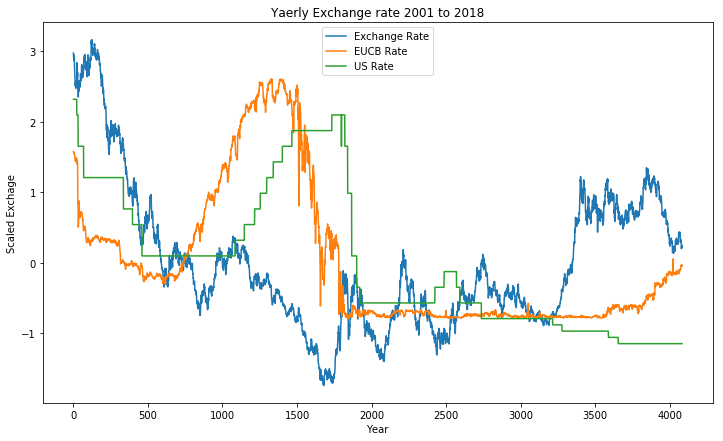

In [808]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use)
#scaled_data = scaler.fit_transform(data_to_use['Value'].values.reshape(-1, 1))
# scaled_data = scaler.fit_transform(data_to_use['EXRATEUSEU'].values.reshape(-1, 1))
# scaled_weekly_data = scaler.fit_transform(eu_weekly_arr_to_use.reshape(-1, 1))
# scaled_monthly_data = scaler.fit_transform(eu_monthly_arr_to_use.reshape(-1, 1))
# scaled_yearly_data = scaler.fit_transform(eu_yearly_arr_to_use.reshape(-1, 1))


#plotting the data
import matplotlib.pyplot as plt
labels=['Exchange Rate', 'EUCB Rate', 'US Rate']
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')

plt.title('Yaerly Exchange rate 2001 to 2018')
plt.xlabel('Year')
plt.ylabel('Scaled Exchage')
plt.plot(scaled_data)
plt.legend(labels, loc='upper center')
# plt.plot(scaled_weekly_data, label='Weekly Rate')
# plt.plot(scaled_monthly_data, label = 'Monthly Rate')
# plt.plot(scaled_yearly_data, label = 'Monthly Rate')
#plt.legend()
plt.show()

In [809]:
# data_df = eu[~eu['Value'].isnull()]
# eu_rates = data_df['Value'].astype(float)
# # eu_rates = eu['Value'].astype(float)
# data_to_use=eu_rates.values
# data_to_use

scaled_data = scaler.fit_transform(data_to_use)
# scaled_data = scaler.fit_transform(data_to_use[0:8])
len(data_to_use)
#scaled_data


4084

In [810]:
# eu['Value']=eu['Value'].fillna(eu['Value'].mean())
# eu_rates = eu['Value'].astype(float)
# data_to_use=eu_rates.values
# data_to_use

In [811]:
# eu[eu['Value'].isnull()]

In [812]:
# check len(X) mod has NO remainder
def check_batch_size(len_X_train):
    if ((len_X_train % batch_size) > 0): 
        print('Waring for partial batch size problem.  Will lost last partial batch data')
        print('X train size : ', len_X_train, 'Batch size : ', batch_size)

In [813]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, window_size_en)


#we now split the data into training and test set
import numpy as np
test_portion = len(X) // training_test_blocks
train_i = len(X) - test_portion

# X_train  = np.array(X[:1018])
# y_train = np.array(y[:1018])

# X_test = np.array(X[1018:])
# y_test = np.array(y[1018:])

X_train  = np.array(X[:train_i])
y_train = np.array(y[:train_i])

X_test = np.array(X[train_i:])
y_test = np.array(y[train_i:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))
check_batch_size(len(X_train))

X_train size: (3252, 20, 3)
y_train size: (3252, 3)
X_test size: (812, 20, 3)
y_test size: (812, 3)


In [814]:
test_portion, len(X), training_test_blocks

(812, 4064, 5)

In [815]:
input_dimension = len(X_train[0][0])

In [816]:
input_dimension

3

In [817]:
#we define the placeholders
#(a Tensorflow variable) of the dimensions [batch_size, sequence_length, input_dimension] 
# inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, 1])
# targets = tf.placeholder(tf.float32, [batch_size, 1])

inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, input_dimension])
targets = tf.placeholder(tf.float32, [batch_size, input_dimension])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
# LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
#     input -> tf.reshape(inputs[i][ii], (-1, 1))
#     output -> batch_state
#     state -> batch_output
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    #output prediction
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros 
    #at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size_en):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    print ('batch_output - > ', batch_output)   
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

batch_output - >  Tensor("mul_710:0", shape=(3, 256), dtype=float32)
batch_output - >  Tensor("mul_770:0", shape=(3, 256), dtype=float32)
batch_output - >  Tensor("mul_830:0", shape=(3, 256), dtype=float32)
batch_output - >  Tensor("mul_890:0", shape=(3, 256), dtype=float32)


[<tf.Tensor 'add_2156:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'add_2337:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'add_2518:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'add_2699:0' shape=(3, 1) dtype=float32>]

In [818]:
len(X_train)

3252

In [837]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
log_timestamp = {}
for i in range(epochs):
    traind_scores = []
    epoch_loss = []
    ii = 0

    while(ii + batch_size) <= len(X_train):
#        print(ii, " : <- ii + batch_size ->: ", (ii + batch_size))
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]    
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        log_timestamp[datetime.datetime.now()] = c
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
#        print(ii, " : -- ii + batch_size --: ", (ii + batch_size))
    if ((i % 10) == 0 or (i==(epochs-1))):
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        

Epoch 0/30  Current loss: 0.03845881670713425


KeyboardInterrupt: 

In [838]:
#np.mean(log_timestamp.values())
log_timestamp

{datetime.datetime(2019, 4, 7, 12, 38, 49, 645127): 4.6511135,
 datetime.datetime(2019, 4, 7, 12, 38, 49, 738875): 4.409104,
 datetime.datetime(2019, 4, 7, 12, 38, 49, 848249): 3.4476283,
 datetime.datetime(2019, 4, 7, 12, 38, 49, 929743): 2.2978702,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 23493): 2.0954635,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 117245): 1.4985085,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 210992): 0.49545902,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 320369): 0.2973395,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 418800): 0.5893934,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 528192): 0.19096555,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 637565): 0.13632658,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 746939): 0.3236437,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 856312): 0.44991815,
 datetime.datetime(2019, 4, 7, 12, 38, 50, 970757): 0.42449892,
 datetime.datetime(2019, 4, 7, 12, 38, 51, 92258): 0.31825197,
 datetime.datetime(2019, 4, 7, 12, 38, 51, 201634): 

In [820]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
#        print(len(traind_scores[i]))
        sup.append(traind_scores[i][j][0])
sup_e =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
#        print(len(traind_scores[i]))
        sup_e.append(traind_scores[i][j][1])
sup_u = []
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
#        print(len(traind_scores[i]))
        sup_u.append(traind_scores[i][j][2])

In [821]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
#    o = session.run(outputs,feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [822]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])


In [823]:
#test_new_inverse = scaler.inverse_transform(tests_new[len(tests_new)-1])
#c = tests_new[len(tests_new)-1].reshape(1,-1)
c = tests_new[len(tests_new)-1].reshape(1,-1)
a = test_new_inverse = scaler.inverse_transform(c)
a

array([[ 0.83604693,  1.1070803 , -0.36478376]], dtype=float32)

In [783]:
#traind_scores
#tests_new
#quick fixed output data extra list layer issue
tests_new_ex = [tests_new]
# tests_new_ex
p_sup_test = []
e_sup_test = []
u_sup_test = []
for i in range(len(tests_new_ex)):
    for j in range(len(tests_new_ex[i])):
#        print(len(traind_scores[i]))
        p_sup_test.append(tests_new_ex[i][j][0])
        u_sup_test.append(tests_new_ex[i][j][1])
        e_sup_test.append(tests_new_ex[i][j][2])
# sup_test

sup_test=[]
for e in range(train_i) : sup_test.append(None)
#for e in p_sup_test: 
 
for e in e_sup_test: 
    sup_test.append(e)


In [788]:
#traind_scores
#tests_new
#quick fixed output data extra list layer issue
tests_new_ex = [tests_new]
# tests_new_ex
p_sup_test = testd_data_set(tests_new_ex, 0)
e_sup_test = testd_data_set(tests_new_ex, 1)
u_sup_test = testd_data_set(tests_new_ex, 2)


In [787]:
#traind_scores
def testd_data_set(tests_new_ex, feature_nloc):
    f_temp_sup_test = []
    for i in range(len(tests_new_ex)):
        for j in range(len(tests_new_ex[i])):
    #        print(len(traind_scores[i]))
            f_temp_sup_test.append(tests_new_ex[i][j][feature_nloc])
#             u_sup_test.append(tests_new_ex[i][j][1])
#             e_sup_test.append(tests_new_ex[i][j][2])
    # sup_test
    temp_sup_test=[]
    for e in range(train_i) : temp_sup_test.append(None)
    #for e in p_sup_test: 
    
    for e in f_temp_sup_test: 
        temp_sup_test.append(e)
    
    return temp_sup_test

In [786]:
len(sup_test)

4064

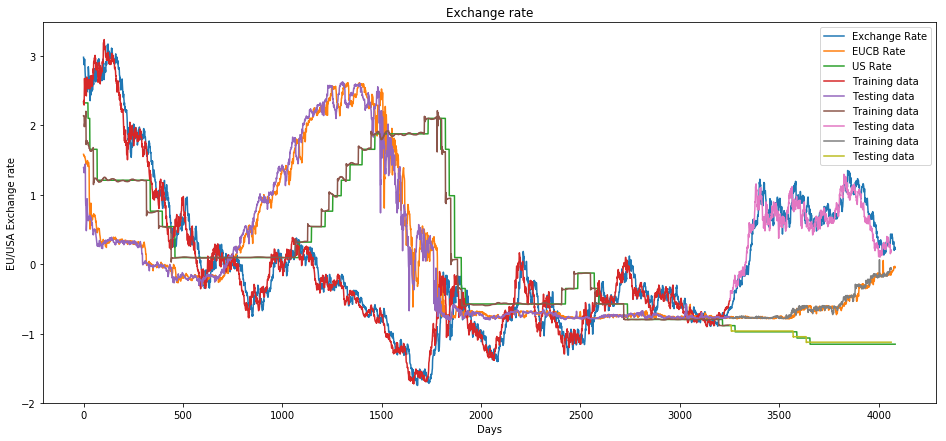

In [796]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Exchange rate')
plt.xlabel('Days')
plt.ylabel('EU/USA Exchange rate')
plt.plot(scaled_data)
plt.plot(sup)
plt.plot(sup_e)
plt.plot(sup_u)

plt.plot(p_sup_test)
plt.plot(e_sup_test)
plt.plot(u_sup_test)
labels.append('Training data')
labels.append('Testing data')
plt.legend(labels, loc='upper right')
#plt.plot(t_n_new, label='Testing data')

# plt.legend()
plt.show()


In [691]:
y[len(y)-10:]

[array([ 0.28757951, -0.08715101, -1.14988305]),
 array([ 0.32586206, -0.08070952, -1.14988305]),
 array([ 0.32586206, -0.04206056, -1.14988305]),
 array([ 0.29395994, -0.03561906, -1.14988305]),
 array([ 0.19916507, -0.04850205, -1.14988305]),
 array([ 0.21557187, -0.04206056, -1.14988305]),
 array([ 0.23653612, -0.03561906, -1.14988305]),
 array([ 0.24929697, -0.02917757, -1.14988305]),
 array([ 0.22377527, -0.04850205, -1.14988305]),
 array([ 0.21557187, -0.04850205, -1.14988305])]

In [318]:
y_new_inverse = scaler.inverse_transform(y[len(y)-1])

In [319]:
y[len(y)-1]

array([ 0.21557187, -0.04850205, -1.14988305])

In [320]:
y_new_inverse

array([ 0.8396,  1.14  , -0.4   ])

In [129]:
# X_new_inverse = scaler.inverse_transform(X[len(X)-1])
# tests


In [144]:
test_results = []
for e in range(train_i):
    tmp = np.empty((1,3))
    tmp[:] = None
    test_results.append(tmp)

# rest from train_i to the end of list
for i in range(len(tests_new)):
#    print("i-> :",i)
    test_results.append(tests_new[i])


In [147]:
test_results[len(test_results)-1]

array([[ 0.20228869],
       [-0.06285695],
       [-1.1351389 ]], dtype=float32)

In [148]:
tests_new

[array([[-0.5352494],
        [-0.7653871],
        [-0.8772781]], dtype=float32), array([[-0.52589834],
        [-0.7527439 ],
        [-0.8772781 ]], dtype=float32), array([[-0.5273305 ],
        [-0.76575154],
        [-0.8772781 ]], dtype=float32), array([[-0.5199944 ],
        [-0.76490146],
        [-0.8772781 ]], dtype=float32), array([[-0.5051826],
        [-0.7656315],
        [-0.8772781]], dtype=float32), array([[-0.49199075],
        [-0.7656315 ],
        [-0.8772781 ]], dtype=float32), array([[-0.49797797],
        [-0.7656315 ],
        [-0.8772781 ]], dtype=float32), array([[-0.38837802],
        [-0.7656315 ],
        [-0.8772781 ]], dtype=float32), array([[-0.40655446],
        [-0.7656315 ],
        [-0.8772781 ]], dtype=float32), array([[-0.39991206],
        [-0.77170366],
        [-0.8772781 ]], dtype=float32), array([[-0.37895238],
        [-0.77164406],
        [-0.8772781 ]], dtype=float32), array([[-0.3793134],
        [-0.7720131],
        [-0.9588267]], dtyp

In [748]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# rms = sqrt(mean_squared_error(y_actual, y_predicted))